# <center> 🦎Reptiles and Amphibians Classification using Deep Convolutional Neural Networks and Transfer Learning </center>


## Installing dataset from kaggle

In [ ]:
#!/bin/bash
!kaggle datasets download vencerlanz09/reptiles-and-amphibians-image-dataset

## Importing all libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
from PIL import Image

import torch
from torchvision import transforms, datasets, utils, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.init as init
import torch.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import time

from pathlib import Path
import os

from sklearn.metrics import classification_report, confusion_matrix
import itertools

## Constants

In [16]:
dataset_folder = './dataset/'

batch_size = 64
num_workers = 0
learning_rate = 1e-3
n_epochs = 10
image_size = 224
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Usefull functions

In [37]:
def freeze_all_layers_except_classifier(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True

In [24]:
def save_log(filename, epoch, loss, accuracy):
    with open(filename, 'a') as f:
        f.write(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss}, Accuracy: {accuracy}\n')

In [25]:
def print_loss_acc(epoch, loss, accuracy):
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss}, Accuracy: {accuracy}')

In [44]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

In [48]:
def validate_model(model, test_loader, criteria):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criteria(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {running_loss / len(test_loader)}, Test Accuracy: {correct / total}')

    return running_loss / len(test_loader)


In [46]:
def train_model(model, train_loader, validation_loader, criteria, optimizer, n_epochs, log_file, model_file, l1 = False, L2 = False, l1_lambda = 1e-3, L2_lambda = 1e-3):
    model.train()
    lowest_loss = np.inf
    for epoch in range(n_epochs):
        for i, data in enumerate(train_loader):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            l1_penalty = l1_lambda * sum(param.abs().sum() for param in model.fc.parameters()) if l1 else 0
            l2_penalty = L2_lambda * sum(param.square().sum() for param in model.fc.parameters()) if L2 else 0
            loss = criteria(outputs, labels) + l1_penalty + l2_penalty
            loss.backward()
            optimizer.step()
        test_loss = validate_model(model, validation_loader, criteria)
        lowest_loss = min(test_loss, lowest_loss)
        print_loss_acc(epoch, loss.item(), (outputs.argmax(1) == labels).sum().item() / len(labels))
        save_log(log_file, epoch, loss.item(), (outputs.argmax(1) == labels).sum().item() / len(labels))

        if test_loss == lowest_loss:
            save_model(model, model_file)

    print('Finished Training')

In [53]:
def present_examples(model, test_loader, class_names):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    num_images = min(16, len(images))
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(12, 12))
    for idx in range(num_images):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        image = images[idx].cpu().numpy().transpose((1, 2, 0))
        image = np.clip(image * 0.229 + 0.485, 0, 1)
        
        ax.imshow(image)
        ax.axis('off')
        
        pred_label = class_names[predicted[idx]]
        true_label = class_names[labels[idx]]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=8, color="blue" if pred_label == true_label else "red")

    plt.tight_layout()
    plt.show()

## Data Transformations

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [30]:
dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

train_size = int(0.5 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size

train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_size, test_size, validation_size])


In [31]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [51]:
class_names = dataset.classes
print("Class names:", class_names)


Class names: ['Chameleon', 'Crocodile_Alligator', 'Frog', 'Gecko', 'Iguana', 'Lizard', 'Salamander', 'Snake', 'Toad', 'Turtle_Tortoise']


## Data example visualization

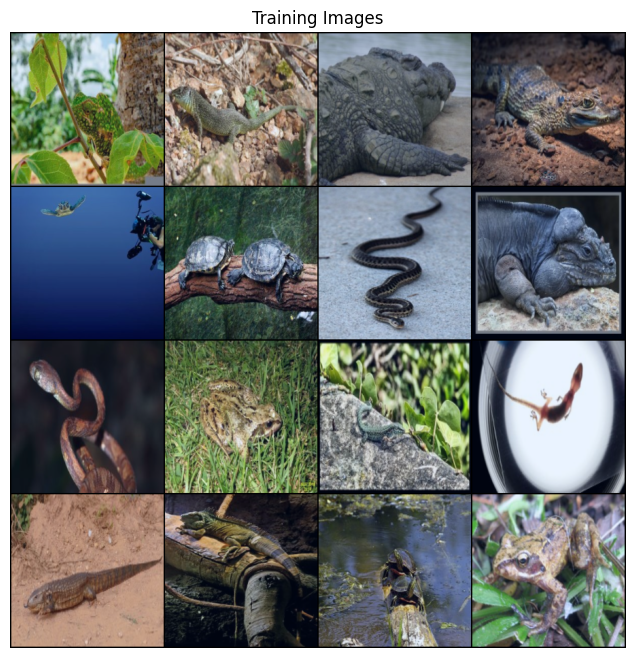

In [22]:
train_loader_iter = iter(train_loader)
images, labels = next(train_loader_iter)
grid = utils.make_grid(images[:16], nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.title('Training Images')
plt.axis('off')
plt.show()

## Implementing models

### Choosen architecture: Pretrained RESNET-50

In [38]:
model = models.resnet50(pretrained=True)
fc_layer = model.fc
model.fc = nn.Linear(fc_layer.in_features, num_classes)
freeze_all_layers_except_classifier(model)

model.to(device)

C:\Users\test\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\test\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
model_file = f"model_resnet50_pretrained.pth"
log_file = f"log_resnet50_pretrained.txt"


train_model(model, train_loader, validation_loader, criteria, optimizer, n_epochs, log_file, model_file)


Test Loss: 0.5461632436827609, Test Accuracy: 0.820364238410596
Epoch 1/10, Loss: 0.3742770552635193, Accuracy: 0.9285714285714286
Test Loss: 0.5390095789181558, Test Accuracy: 0.8137417218543046
Epoch 2/10, Loss: 0.8306349515914917, Accuracy: 0.6428571428571429
Test Loss: 0.5444429461893282, Test Accuracy: 0.8054635761589404
Epoch 3/10, Loss: 0.1630016267299652, Accuracy: 0.9285714285714286
Test Loss: 0.5398546135739276, Test Accuracy: 0.8153973509933775
Epoch 4/10, Loss: 0.48396995663642883, Accuracy: 0.7857142857142857
Test Loss: 0.522630933083986, Test Accuracy: 0.8228476821192053
Epoch 5/10, Loss: 1.0130051374435425, Accuracy: 0.5714285714285714
Test Loss: 0.5074388275021001, Test Accuracy: 0.8228476821192053
Epoch 6/10, Loss: 0.6508806347846985, Accuracy: 0.7857142857142857
Test Loss: 0.5212024685583616, Test Accuracy: 0.8228476821192053
Epoch 7/10, Loss: 0.3691936135292053, Accuracy: 0.8571428571428571
Test Loss: 0.5163791132600684, Test Accuracy: 0.8245033112582781
Epoch 8/10, 

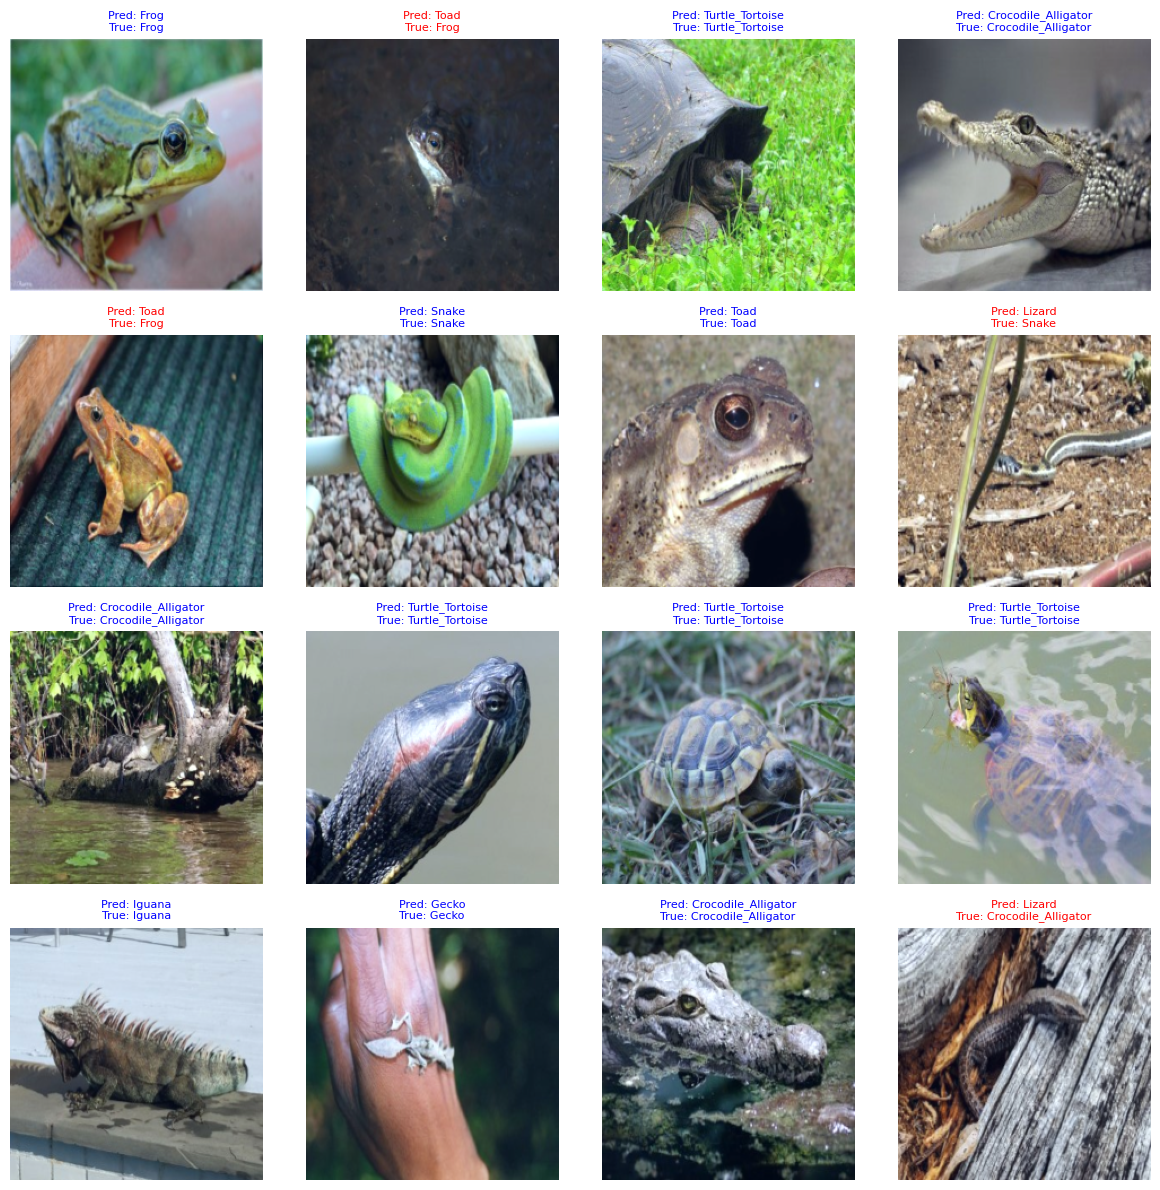

In [54]:
present_examples(model, test_loader, class_names=class_names)